# Model Evaluation

This notebook loads all trained models from the `models/` folder, generates predictions on the test set, converts from log-space back to dollars, computes evaluation metrics (MAE, MSE, RMSE, R-Squared), and visualizes a comparison across models.

In [1]:
import os
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

## Load Data

We use the same test split produced during preprocessing. Targets are in log-space and must be inverse-transformed for metrics.

In [2]:
df_test = pd.read_csv('data/test_data.csv')

X_test = df_test.drop(columns=['baseFare'])
y_test_log = df_test['baseFare'].values

y_test = np.expm1(y_test_log)

print(f"Test shape: {X_test.shape}, target length: {len(y_test)}")

Test shape: (31418, 49), target length: 31418


## Load Models

Load each model file explicitly. All models predict in log-space; we convert predictions back to dollars with `np.expm1()` before computing metrics. The neural network is saved as a Keras model.

In [3]:
RF_PATH = 'models/random_forest_model.pkl'
XGB_PATH = 'models/xgboost_regressor.pkl'
KNN_UNIFORM_PATH = 'models/knn_uniform.pkl'
KNN_DISTANCE_PATH = 'models/knn_distance.pkl'
NN_KERAS_PATH = 'models/nn_model.keras'
OLS_PATH = 'models/ols_pipeline.pkl'
LASSO_PATH = 'models/lasso_pipeline.pkl'
RIDGE_PATH = 'models/ridge_pipeline.pkl'

## Evaluate Models

For each model: load, then predict log-values, then inverse-transform, then compute metrics on original dollar scale

Helper Functions:

In [4]:
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def load_keras(path):
    if keras is None:
        raise RuntimeError("Keras not available to load model: " + path)
    return keras.models.load_model(path)

def predict_log_pickle(model, X):
    return model.predict(X)

def predict_log_keras(model, X):
    preds = model.predict(X, verbose=0)
    return preds.reshape(-1)

def compute_metrics(y_true_dollars, y_pred_dollars):
    mae = mean_absolute_error(y_true_dollars, y_pred_dollars)
    mse = mean_squared_error(y_true_dollars, y_pred_dollars)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_dollars, y_pred_dollars)
    return mae, mse, rmse, r2

results = []

Define Scaler:

In [5]:
scaler = load_pickle('models/scaler.pkl')

1) Random Forest

In [6]:
rf_model = load_pickle('models/random_forest_model.pkl')
y_pred_log_rf = predict_log_pickle(rf_model, X_test)
y_pred_rf = np.expm1(y_pred_log_rf)
mae_rf, mse_rf, rmse_rf, r2_rf = compute_metrics(y_test, y_pred_rf)
results.append({'Model': 'Random Forest', 'MAE': mae_rf, 'MSE': mse_rf, 'RMSE': rmse_rf, 'R-Squared': r2_rf})
print(f"Random Forest: RMSE=${rmse_rf:.2f}, MAE=${mae_rf:.2f}, R-Squared={r2_rf:.4f}")

Random Forest: RMSE=$57.19, MAE=$25.54, R-Squared=0.7617


2) XGBoost

In [7]:
xgb_model = load_pickle('models/xgboost_regressor.pkl')
y_pred_log_xgb = predict_log_pickle(xgb_model, X_test)
y_pred_xgb = np.expm1(y_pred_log_xgb)
mae_xgb, mse_xgb, rmse_xgb, r2_xgb = compute_metrics(y_test, y_pred_xgb)
results.append({'Model': 'XGBoost', 'MAE': mae_xgb, 'MSE': mse_xgb, 'RMSE': rmse_xgb, 'R-Squared': r2_xgb})
print(f"XGBoost: RMSE=${rmse_xgb:.2f}, MAE=${mae_xgb:.2f}, R-Squared={r2_xgb:.4f}")

XGBoost: RMSE=$51.79, MAE=$23.35, R-Squared=0.8047


/var/folders/g5/7333cfr56lq65wwv2srcqzv80000gn/T/ipykernel_75075/3411908978.py:3: UserWarning: [18:34:40] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/../common/error_msg.h:83: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  return pickle.load(f)


3) KNN (uniform)

**Note:** KNN models require feature scaling. We need to scale the same features that were scaled during training.

In [8]:
features_to_scale = ['seatsRemaining', 'Booking Lead Time', 'travelDuration_minutes', 'departureTime_sin', 'departureTime_cos']

train_data = pd.read_csv('data/train_data.csv')

target_column = 'baseFare'
all_feature_columns = train_data.columns.tolist()
if target_column in all_feature_columns:
    all_feature_columns.remove(target_column)

airport_features = [col for col in all_feature_columns if col.startswith(('startingAirport_', 'destinationAirport_'))]
airline_features = [col for col in all_feature_columns if col.startswith('segmentsAirlineName_')]
continuous_features = [col for col in all_feature_columns if not col.startswith(('startingAirport_', 'destinationAirport_', 'segmentsAirlineName_', 'isBasicEconomy' , 'elapsedDays'))]
boolean_features = [col for col in all_feature_columns if col.startswith(('isBasicEconomy', 'elapsedDays'))]

continuous_scaled = [col for col in continuous_features if col in features_to_scale]
continuous_unscaled = [col for col in continuous_features if col not in features_to_scale]

feature_columns = continuous_scaled + continuous_unscaled + airport_features + airline_features + boolean_features

X_test_ordered = X_test[feature_columns].copy()

X_test_scaled = X_test_ordered.copy()
X_test_scaled[features_to_scale] = scaler.transform(X_test_ordered[features_to_scale])

print(f"Scaled features: {features_to_scale}")
print(f"Feature column order: continuous_scaled + continuous_unscaled + airports + airlines + boolean")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"First few column names: {X_test_scaled.columns[:10].tolist()}")

Scaled features: ['seatsRemaining', 'Booking Lead Time', 'travelDuration_minutes', 'departureTime_sin', 'departureTime_cos']
Feature column order: continuous_scaled + continuous_unscaled + airports + airlines + boolean
X_test_scaled shape: (31418, 49)
First few column names: ['seatsRemaining', 'Booking Lead Time', 'departureTime_sin', 'departureTime_cos', 'travelDuration_minutes', 'dayOfWeek_Monday', 'dayOfWeek_Saturday', 'dayOfWeek_Sunday', 'dayOfWeek_Thursday', 'dayOfWeek_Tuesday']


In [9]:
knn_uniform_model = load_pickle('models/knn_uniform.pkl')
y_pred_log_knn_uniform = predict_log_pickle(knn_uniform_model, X_test_scaled.values)
y_pred_knn_uniform = np.expm1(y_pred_log_knn_uniform)
mae_knn_uniform, mse_knn_uniform, rmse_knn_uniform, r2_knn_uniform = compute_metrics(y_test, y_pred_knn_uniform)
results.append({'Model': 'KNN (uniform)', 'MAE': mae_knn_uniform, 'MSE': mse_knn_uniform, 'RMSE': rmse_knn_uniform, 'R-Squared': r2_knn_uniform})
print(f"KNN (uniform): RMSE=${rmse_knn_uniform:.2f}, MAE=${mae_knn_uniform:.2f}, R-Squared={r2_knn_uniform:.4f}")

KNN (uniform): RMSE=$65.78, MAE=$34.38, R-Squared=0.6849


4) KNN (distance)

In [10]:
knn_distance_model = load_pickle('models/knn_distance.pkl')
y_pred_log_knn_distance = predict_log_pickle(knn_distance_model, X_test_scaled.values)  # Convert to numpy array
y_pred_knn_distance = np.expm1(y_pred_log_knn_distance)
mae_knn_distance, mse_knn_distance, rmse_knn_distance, r2_knn_distance = compute_metrics(y_test, y_pred_knn_distance)
results.append({'Model': 'KNN (distance)', 'MAE': mae_knn_distance, 'MSE': mse_knn_distance, 'RMSE': rmse_knn_distance, 'R-Squared': r2_knn_distance})
print(f"KNN (distance): RMSE=${rmse_knn_distance:.2f}, MAE=${mae_knn_distance:.2f}, R-Squared={r2_knn_distance:.4f}")

KNN (distance): RMSE=$64.50, MAE=$33.19, R-Squared=0.6970


5) Neural Network (Keras)

In [11]:
X_test_nn_scaled = X_test.copy()
X_test_nn_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

nn_model = load_keras('models/neural_network.keras')
y_pred_log_nn = predict_log_keras(nn_model, X_test_nn_scaled.values)
y_pred_nn = np.expm1(y_pred_log_nn)
mae_nn, mse_nn, rmse_nn, r2_nn = compute_metrics(y_test, y_pred_nn)
results.append({'Model': 'Neural Network (Keras)', 'MAE': mae_nn, 'MSE': mse_nn, 'RMSE': rmse_nn, 'R-Squared': r2_nn})
print(f"Neural Network (Keras): RMSE=${rmse_nn:.2f}, MAE=${mae_nn:.2f}, R-Squared={r2_nn:.4f}")

Neural Network (Keras): RMSE=$56.64, MAE=$25.75, R-Squared=0.7663


6. OLS

In [12]:
ols_model = load_pickle('models/ols_pipeline.pkl')
y_pred_log_ols = predict_log_pickle(ols_model, X_test)
y_pred_ols = np.expm1(y_pred_log_ols)
mae_ols, mse_ols, rmse_ols, r2_ols = compute_metrics(y_test, y_pred_ols)
results.append({'Model': 'OLS', 'MAE': mae_ols, 'MSE': mse_ols, 'RMSE': rmse_ols, 'R-Squared': r2_ols})
print(f"OLS: RMSE=${rmse_ols:.2f}, MAE=${mae_ols:.2f}, R-Squared={r2_ols:.4f}")

OLS: RMSE=$80.04, MAE=$47.83, R-Squared=0.5334


7. Lasso Regression

In [13]:
lasso_model = load_pickle('models/lasso_pipeline.pkl')
y_pred_log_lasso = predict_log_pickle(lasso_model, X_test)
y_pred_lasso = np.expm1(y_pred_log_lasso)
mae_lasso, mse_lasso, rmse_lasso, r2_lasso = compute_metrics(y_test, y_pred_lasso)
results.append({'Model': 'Lasso', 'MAE': mae_lasso, 'MSE': mse_lasso, 'RMSE': rmse_lasso, 'R-Squared': r2_lasso})
print(f"Lasso: RMSE=${rmse_lasso:.2f}, MAE=${mae_lasso:.2f}, R-Squared={r2_lasso:.4f}")


Lasso: RMSE=$81.05, MAE=$48.89, R-Squared=0.5216


8. Ridge Regression

In [14]:
ridge_model = load_pickle('models/ridge_pipeline.pkl')
y_pred_log_ridge = predict_log_pickle(ridge_model, X_test)
y_pred_ridge = np.expm1(y_pred_log_ridge)
mae_ridge, mse_ridge, rmse_ridge, r2_ridge = compute_metrics(y_test, y_pred_ridge)
results.append({'Model': 'Ridge', 'MAE': mae_ridge, 'MSE': mse_ridge, 'RMSE': rmse_ridge, 'R-Squared': r2_ridge})
print(f"Ridge: RMSE=${rmse_ridge:.2f}, MAE=${mae_ridge:.2f}, R-Squared={r2_ridge:.4f}")

Ridge: RMSE=$80.03, MAE=$47.83, R-Squared=0.5335


In [15]:
results_df = pd.DataFrame(results).sort_values(['RMSE', 'MAE']).reset_index(drop=True)
results_df

,Model,MAE,MSE,RMSE,R-Squared
0,XGBoost,23.353303,2681.947780,51.787525,0.804653
1,Neural Network (Keras),25.746521,3208.162216,56.640641,0.766325
2,Random Forest,25.537243,3271.069804,57.193267,0.761743
3,KNN (distance),33.187030,4159.882309,64.497150,0.697003
4,KNN (uniform),34.380924,4326.396996,65.775352,0.684875
5,Ridge,47.833097,6405.304378,80.033145,0.533452
6,OLS,47.834917,6406.112702,80.038195,0.533393
7,Lasso,48.887931,6568.341645,81.045306,0.521577


## Visualization

Bar charts comparing MAE, MSE, RMSE, and R-Squared across all models.

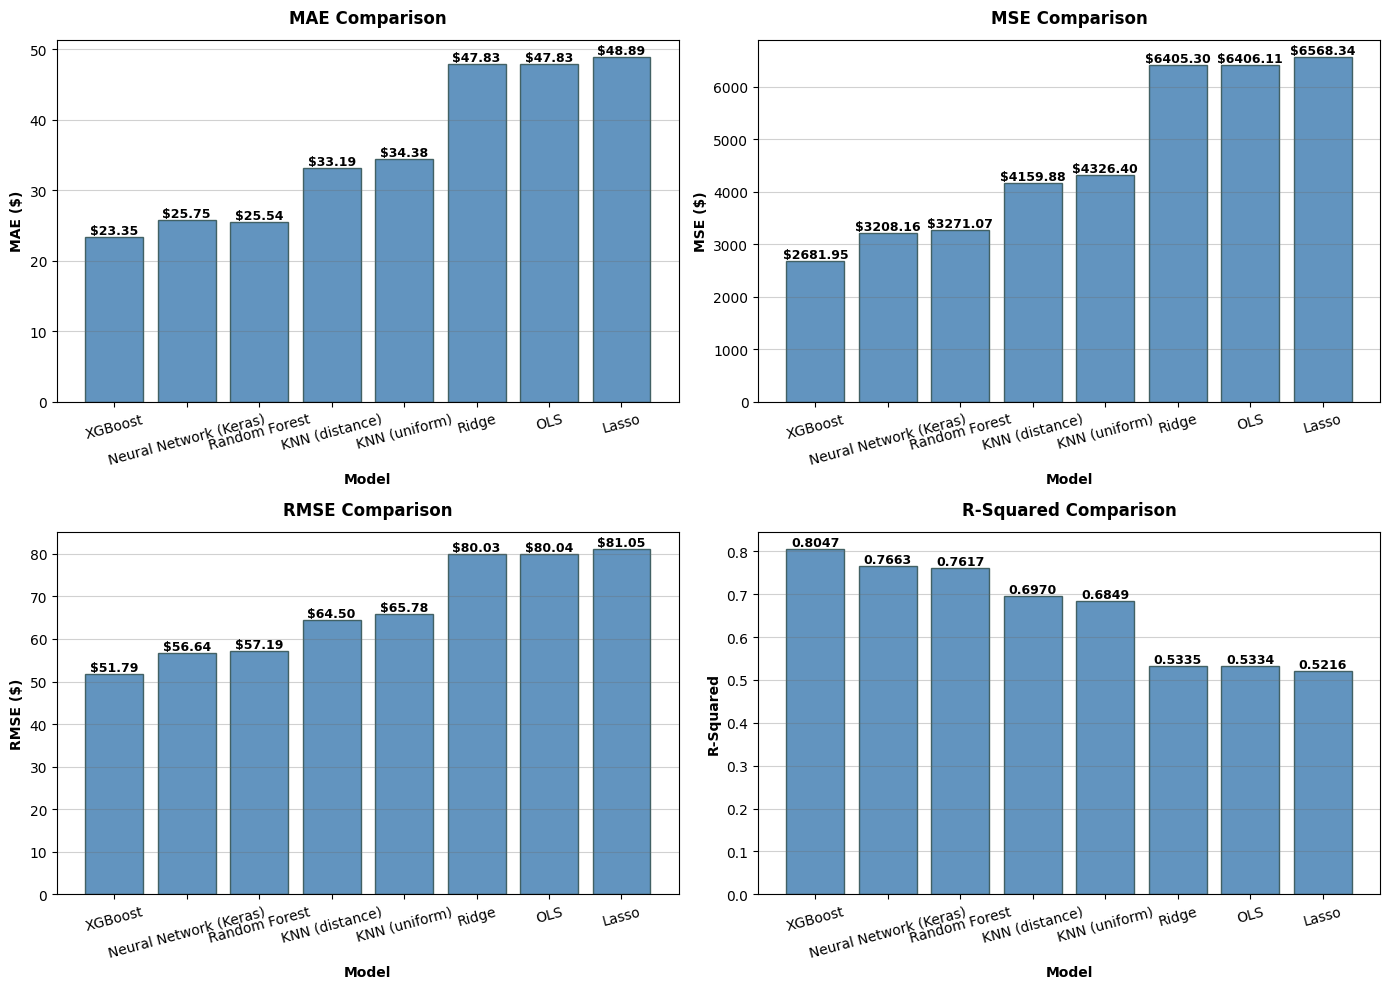

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['MAE', 'MSE', 'RMSE', 'R-Squared']
colors = ['steelblue'] * len(results_df)

for idx, metric in enumerate(metrics):
    r = idx // 2
    c = idx % 2
    ax = axes[r, c]

    vals = results_df[metric].values
    labels = results_df['Model'].values
    x = np.arange(len(vals))

    bars = ax.bar(x, vals, color=colors, edgecolor='darkslategray', alpha=0.85)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=15)
    ax.set_title(f'{metric} Comparison', fontweight='bold', pad=12)
    ax.set_xlabel('Model', fontweight='bold')
    if metric in ['MAE', 'MSE', 'RMSE']:
        ax.set_ylabel(f'{metric} ($)', fontweight='bold')
    else:
        ax.set_ylabel(metric, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, color='dimgray')

    for i, bar in enumerate(bars):
        v = vals[i]
        label = f'{v:.4f}' if metric == 'R-Squared' else f'${v:.2f}'
        ax.text(bar.get_x() + bar.get_width()/2, v, label, ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

## Save Results

Persist evaluation metrics for later reporting/analysis.

In [17]:
results_df.to_csv('data/evaluation_results.csv', index=False)